<a href="https://colab.research.google.com/github/ekomissarov/data-analysis/blob/main/rfm_segmentation_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
#@title importing libraries
from google.colab import drive
import pandas as pd
import numpy as np
import time
from datetime import date, datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

sns.set_style("darkgrid")
sns.set_context("paper")

def display_df(df=None):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(df)



In [172]:
#@title mounting Google drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [173]:
#@title reading original csv
sessions = pd.read_csv('gdrive/MyDrive/public_data/ch04_final_visits.csv')
sessions['session_start'] = pd.to_datetime(sessions['session_start'])
sessions = sessions.drop(columns=['last_ts'])

orders = pd.read_csv('gdrive/MyDrive/public_data/ch04_final_orders.csv')
orders['event_dt'] = pd.to_datetime(orders['event_dt'])


In [174]:
#@title PREVIEW sessions journal display
print(f"min session start: {sessions.session_start.min()}, \nmax session start: {sessions.session_start.max()}\n")
print(f"unique users: {sessions.user_id.nunique()}\n\n")
display(sessions)

min session start: 2019-08-08 00:02:14, 
max session start: 2019-11-19 23:56:19

unique users: 74998




,user_id,region,device,channel,session_duration,session_start
0,719996753603,South Korea,iPhone,Gooble,50.031243,2019-08-08 11:25:01
1,436264470361,Japan,iPhone,Gooble,4.911651,2019-08-08 16:15:36
2,806291882350,Japan,iPhone,FaceNotebook,54.222802,2019-08-08 22:25:44
3,495453983262,South Korea,iPhone,FaceNotebook,8.471813,2019-08-08 12:51:14
4,130312936062,Japan,iPhone,Gooble,123.380154,2019-08-08 08:17:03
...,...,...,...,...,...,...
153130,493258034727,Japan,Android,FaceNotebook,45.089999,2019-11-19 12:05:30
153131,169117476965,Japan,iPad,FaceNotebook,8.373878,2019-11-19 16:12:17
153132,117818540374,Japan,iPad,Gooble,1.390599,2019-11-19 02:32:32
153133,98848646467,Japan,Android,FaceNotebook,39.257917,2019-11-19 18:50:56


In [175]:
#@title PREVIEW orders journal display
display(orders)

,user_id,event_dt,revenue
0,495453983262,2019-08-08 12:51:22,2.5
1,344715136375,2019-08-08 22:05:57,5.5
2,625251125771,2019-08-08 15:24:58,5.5
3,556027424293,2019-08-08 12:04:46,50.0
4,937033752203,2019-08-08 09:06:12,50.0
...,...,...,...
13456,871758953707,2019-11-19 14:06:15,2.5
13457,462208386216,2019-11-19 04:22:11,2.5
13458,606521718494,2019-11-19 04:00:04,5.5
13459,117818540374,2019-11-19 02:32:32,2.5


In [176]:
#@title get_profiles function
def get_profiles(sessions, purchase_events=None, events=None, ad_costs=None, event_names=[]):
    """
    На вход принимает "журнал посещений" и "журнал заказов".
    А так же журнал событий и рекламные затраты

    Журнал посещений содержит следующие обязательные поля:
    user_id, session_start, session_duration, и др. доп информация такая как устройство, гео, язык и пр.
    На вход можно передать журнал покупок, который содержит user_id, дату покупки и сумму покупки

    Функция возвращает профили пользователей
    user_id
    first_ts момент первой сессии, обычно это дата, вычесленная по журналу посещений (на анализируемом периоде),
             доп информацию первого посещения (момент первой сессии и доп инфу необходимо обработать отдельно дописав код функции),
    cohort_moment по журналу посещений, дату когорты пользователя,
    purchase_event является ли пользователь покупателем (если передан журнал покупок)
    другие события если передан журнал событий и их названия
    cohort_cac если переданы рекламные затраты
    """
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
                # другие параметры
            }
        )
        .rename(columns={
            'user_id': 'user_id',
            'session_start': 'first_ts',
            'channel': 'first_channel',
            'device': 'first_device',
            'region': 'first_region',
        }).reset_index()
    )

    profiles['cohort_moment'] = profiles['first_ts'].dt.date
    #profiles['cohort_moment'] = profiles['first_ts'].to_numpy().astype('datetime64[M]')

    # добавляем флаги покупок, дату первой покупки и сумму первой покупки
    if purchase_events is not None:
        first_purchase = (
            purchase_events
            .sort_values(by=['user_id', 'event_dt'])
            .groupby('user_id')
            .agg({
                'event_dt': 'first',
                'revenue': 'first'
            })
            .rename(columns={'revenue': 'first_revenue',
                             'event_dt': 'first_purchase'})
            .reset_index()
        )
        profiles = profiles.merge(first_purchase, how='left', on='user_id')
        profiles['purchase_event'] = profiles['user_id'].isin(first_purchase.user_id.unique())


    # добавляем флаги для всех событий из event_names
    if events is not None:
        for ev in event_names:
            if ev in events['event_name'].unique():
                # проверяем, встречается ли каждый пользователь
                # среди тех, кто совершил событие event
                profiles[ev] = profiles['user_id'].isin(events.query('event_name == @ev')['uid'].unique())

    if ad_costs is not None:
        # считаем количество уникальных пользователей
        # с одинаковыми источником и датой привлечения
        new_users = (
            profiles.groupby(['cohort_moment', 'first_channel'])
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'unique_users'})
            .reset_index()
        )

        # объединяем траты на рекламу и число привлечённых пользователей
        # по дате и каналу привлечения и вычисляем CAC
        ad_costs = ad_costs.merge(
            new_users,
            left_on=['dt', 'channel'],
            right_on=['cohort_moment', 'first_channel'],
            how='left').drop(columns=['dt', 'channel'])
        ad_costs['cohort_cac'] = ad_costs['costs'] / ad_costs['unique_users']

        # добавим стоимость привлечения в профили
        profiles = profiles.merge(ad_costs, on=['cohort_moment', 'first_channel'], how='left')

        # органические пользователи не связаны с данными о рекламе,
        # поэтому в столбце cohort_cac у них значения NaN
        # заменим их на ноль, ведь стоимость привлечения равна нулю
        profiles['cohort_cac'] = profiles['cohort_cac'].fillna(0)

    if profiles.user_id.nunique() != len(profiles):
        raise Exception("Profiling error")

    return profiles


# строим профили по двум наборам данных
profiles = get_profiles(sessions, purchase_events=orders,)

print(f"min cohort_moment {profiles.cohort_moment.min()}, \nmax cohort_moment {profiles.cohort_moment.max()}\n\n")
display(profiles.sort_values('cohort_moment'))

min cohort_moment 2019-08-08, 
max cohort_moment 2019-11-05




,user_id,first_ts,first_channel,first_device,first_region,cohort_moment,first_purchase,first_revenue,purchase_event
73045,974424962027,2019-08-08 12:06:23,Gooble,iPhone,Japan,2019-08-08,NaT,NaN,False
70410,937848854013,2019-08-08 09:49:12,FaceNotebook,iPhone,Japan,2019-08-08,NaT,NaN,False
35374,473018080025,2019-08-08 09:01:48,FaceNotebook,iPhone,Japan,2019-08-08,NaT,NaN,False
16411,220103425425,2019-08-08 18:16:08,FaceNotebook,iPhone,Singapore,2019-08-08,NaT,NaN,False
44403,593106348009,2019-08-08 09:04:26,FaceNotebook,iPhone,Singapore,2019-08-08,NaT,NaN,False
...,...,...,...,...,...,...,...,...,...
69833,929505067049,2019-11-05 14:04:46,Gooble,iPhone,Japan,2019-11-05,NaT,NaN,False
18616,248436001186,2019-11-05 17:17:01,FaceNotebook,iPhone,South Korea,2019-11-05,NaT,NaN,False
34318,458625544475,2019-11-05 07:25:58,Gooble,Android,Japan,2019-11-05,NaT,NaN,False
53631,714320674731,2019-11-05 06:45:45,Gooble,Android,South Korea,2019-11-05,NaT,NaN,False


In [177]:
#@title get data for rfm segmentation
df = orders.merge(profiles, on='user_id', how='left')[[
    'user_id', 'event_dt', 'revenue',
    'first_channel', 'first_device', 'first_region', 'cohort_moment', 'first_revenue'
]]
df

,user_id,event_dt,revenue,first_channel,first_device,first_region,cohort_moment,first_revenue
0,495453983262,2019-08-08 12:51:22,2.5,FaceNotebook,iPhone,South Korea,2019-08-08,2.5
1,344715136375,2019-08-08 22:05:57,5.5,Gooble,iPhone,South Korea,2019-08-08,5.5
2,625251125771,2019-08-08 15:24:58,5.5,FaceNotebook,iPhone,Japan,2019-08-08,5.5
3,556027424293,2019-08-08 12:04:46,50.0,Gooble,iPhone,South Korea,2019-08-08,50.0
4,937033752203,2019-08-08 09:06:12,50.0,Gooble,iPhone,South Korea,2019-08-08,50.0
...,...,...,...,...,...,...,...,...
13456,871758953707,2019-11-19 14:06:15,2.5,FaceNotebook,iPad,Japan,2019-11-03,2.5
13457,462208386216,2019-11-19 04:22:11,2.5,FaceNotebook,iPad,Hong Kong,2019-11-03,5.5
13458,606521718494,2019-11-19 04:00:04,5.5,FaceNotebook,Android,Singapore,2019-11-04,2.5
13459,117818540374,2019-11-19 02:32:32,2.5,Gooble,iPad,Japan,2019-11-05,2.5


<Axes: xlabel='first_region'>

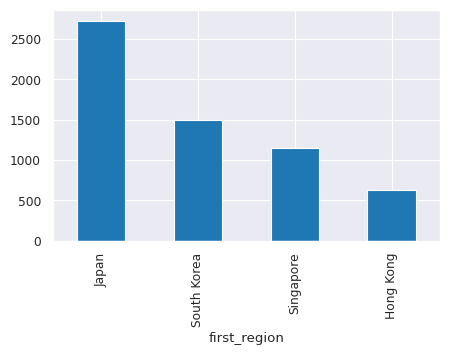

In [178]:
#@title researching data (and filtering if needed)
df.groupby('first_region')['user_id'].agg('nunique').sort_values(ascending=False)[:10].plot(kind='bar', figsize=(5,3))

In [180]:
#@title recency frequency monetery columns
PRESENT = datetime(2019,11,20) # самая новая дата
rfm = (
    df.groupby('user_id')
    .agg({
        'event_dt': lambda x: (PRESENT - x.max()).days,
        'revenue': ['count', 'sum'],
    })
)

rfm.columns = ['recency', 'frequency', 'monetary']
rfm.head()

,recency,frequency,monetary
user_id,,,
102328065,93,1,5.5
136662463,16,2,5.0
285017219,20,1,2.5
322288812,15,1,5.5
327093425,5,3,10.5


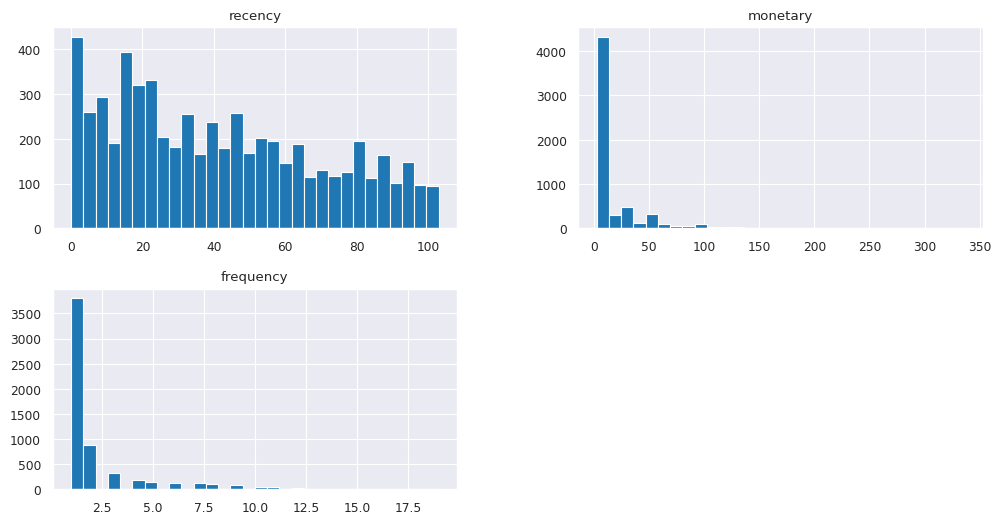

In [141]:
#@title rfm histograms
rfm[['recency', 'monetary', 'frequency']].hist(figsize=(12,6), bins=30);

In [ ]:
#@title calculating logarithms if needed (for quartile segmentation)
rfm[['recency', 'monetary', 'frequency']].apply(lambda w: np.log(w + 1)).hist(figsize=(12,6), bins=30)
#rfm[['recency', 'frequency', 'monetary']] = rfm[['recency', 'frequency', 'monetary']].apply(lambda w: np.log(w + 1))

In [182]:
#@title quartile segmentation(if possible) and example of custom function segmentation
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])

def monetary_class(x):
    if x<=2.5:
        return '4'
    elif x<=5.5:
        return '3'
    elif x<=10:
        return '2'
    return '1'
def freq_class(x):
    if x<=1:
        return '4'
    elif x<=2:
        return '3'
    elif x<=3:
        return '2'
    return '1'

rfm['m_group'] = rfm.monetary.map(monetary_class)
rfm['f_group'] = rfm.frequency.map(freq_class)

In [184]:
#@title rfm score
rfm['RFM_Score'] = rfm.r_quartile.astype(str) + rfm.f_group.astype(str) + rfm.m_group.astype(str)
rfm

,recency,frequency,monetary,r_quartile,m_group,f_group,RFM_Score
user_id,,,,,,,
102328065,93,1,5.5,4,3,4,443
136662463,16,2,5.0,1,3,3,133
285017219,20,1,2.5,2,4,4,244
322288812,15,1,5.5,1,3,4,143
327093425,5,3,10.5,1,1,2,121
...,...,...,...,...,...,...,...
998604052069,27,1,2.5,2,4,4,244
998714347122,53,1,5.5,3,3,4,343
999141393529,2,7,51.0,1,1,1,111


In [186]:
#@title number of items in rff segments
rfm['RFM_Score'].value_counts()

RFM_Score
444    794
344    745
111    740
244    634
144    260
343    191
443    188
211    165
441    145
243    138
442    120
342    116
341    112
241    109
121    107
131    107
233    107
333     99
242     90
231     87
331     85
133     82
431     78
143     75
433     73
232     48
221     47
142     45
132     44
321     44
122     42
332     40
141     40
432     38
421     30
222     28
311     25
322     25
112     22
422     13
411      6
212      3
412      2
312      2
Name: count, dtype: int64

In [189]:
#@title best buyers & worst buyers
display(rfm[rfm['RFM_Score'] == '111'].sort_values('monetary', ascending=False).head())  #best
display(rfm[rfm['RFM_Score'] == '444'].sort_values('monetary', ascending=False).head())

,recency,frequency,monetary,r_quartile,m_group,f_group,RFM_Score
user_id,,,,,,,
579124948949,16,9,336.0,1,1,1,111
790150751757,5,8,218.0,1,1,1,111
681978189976,12,12,213.5,1,1,1,111
564624989573,0,11,196.5,1,1,1,111
738435251381,9,7,193.0,1,1,1,111


,recency,frequency,monetary,r_quartile,m_group,f_group,RFM_Score
user_id,,,,,,,
947896415,85,1,2.5,4,4,4,444
616291811907,83,1,2.5,4,4,4,444
617426784213,89,1,2.5,4,4,4,444
621966924911,70,1,2.5,4,4,4,444
623777037202,80,1,2.5,4,4,4,444


In [190]:
#title what clusters are big?
clusters = rfm['RFM_Score'].value_counts()
big_clusters = clusters[clusters > 100].index.values
big_clusters

array(['444', '344', '111', '244', '144', '343', '443', '211', '441',
       '243', '442', '342', '341', '241', '121', '131', '233'],
      dtype=object)

In [ ]:
#@title scatter 3d
px.scatter_3d(
    rfm[rfm.RFM_Score.isin(big_clusters)],
    x='recency',
    y='frequency',
    z='monetary',
    color='RFM_Score'
)